# Imports


In [1]:
import tensorboard
import matplotlib.pyplot as plot
import statistics
from DatasetFormatting import *
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
import numpy as np
import tensorflow.keras.layers as Layer
import tensorflow as tf
import pandas as pd
%load_ext tensorboard
from sklearn.model_selection import train_test_split
import sklearn.naive_bayes as NB


# Preparing Training Dataset


STD: 0.9976277124059775
mean: 6.165617412034789
variance: 0.9952610525603838
mode: 6.5
x_train shape: (16989,)


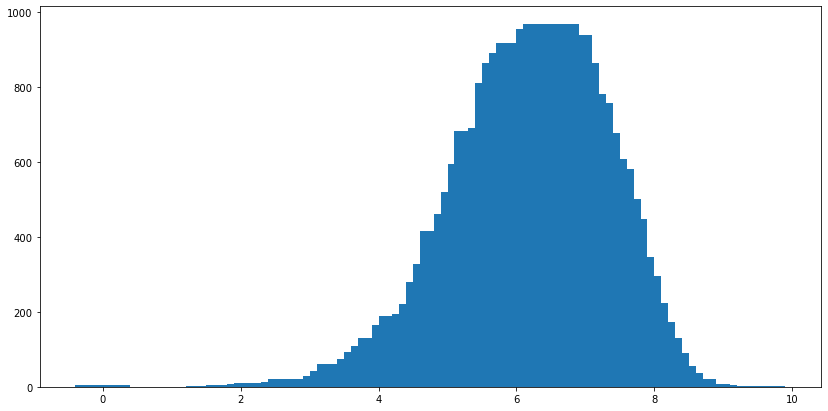

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

movie_df = getData()
movie_df.drop(['vote_count'], axis=1)

data_count = movie_df.shape[0]
training_data_count = int(data_count * 0.75) + 1
test_data_count = data_count - training_data_count

y_train = np.array(movie_df['vote_average'].head(training_data_count))
x_train = np.array(movie_df['training_col'].head(training_data_count))

y_test = np.array(movie_df['vote_average'].tail(test_data_count))
x_test = np.array(movie_df[['training_col']].tail(test_data_count))

std = statistics.stdev(movie_df['vote_average'].to_list())
mean = statistics.mean(movie_df['vote_average'].to_list())
variance = statistics.variance(movie_df['vote_average'].to_list())
mode = statistics.mode(movie_df['vote_average'].to_list())

print(f"STD: {std}")
print(f"mean: {mean}")
print(f"variance: {variance}")
print(f"mode: {mode}")

# print(x_train)
print(f"x_train shape: {x_train.shape}")

plot.figure(figsize=[14, 7])
scores = movie_df['vote_average'].to_list()
unique, counts = np.unique(scores, return_counts=True)
plot.bar(unique, counts)

plot.show()


### Text Vectorization For Actors & Genres


In [3]:
VOCAB_SIZE = 201277
encoder = preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, output_sequence_length=6)
features = np.array(movie_df['training_col'])
encoder.adapt(features)

# this line of code doesnt work on windows for some reason
# print(np.array(encoder.get_vocabulary()))


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2021-11-24 14:26:30.714515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-24 14:26:30.714816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-11-24 14:26:30.745567: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-24 14:26:30.747891: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-24 14:26:30.783445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


### Text Vectorization Sanity Check


In [4]:
print(movie_df['training_col'].to_numpy()[0])
x = encoder(movie_df['training_col'].to_numpy()[0]).numpy()
x


Horror DakotaFanning JosePabloCantillo


array([   5,  325, 3016,    0,    0,    0])

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Feed Forward Neural Network


### Building The FFNN


In [77]:
model_FFNN = tf.keras.Sequential([
    encoder,
    Layer.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=500),
    Layer.Flatten(input_shape=(16989, 1)),
    Layer.Dense(56, activation='tanh'),
    Layer.Dense(125, activation='tanh'),
    Layer.Dense(104, activation='tanh'),
    Layer.Dense(120, activation='tanh'),
    Layer.Dense(1)
])

model_FFNN.summary()

model_FFNN.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.RMSprop(.001))


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 6)                 0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 6, 500)            20632500  
_________________________________________________________________
flatten_5 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 56)                168056    
_________________________________________________________________
dense_86 (Dense)             (None, 125)               7125      
_________________________________________________________________
dense_87 (Dense)             (None, 104)               13104     
_________________________________________________________________
dense_88 (Dense)             (None, 120)             

### Training The FFNN


Epoch 1/10


2021-11-24 15:25:42.766308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


67/67 [==============================] - 2s 28ms/step - loss: 2.8502
Epoch 2/10
67/67 [==============================] - 2s 26ms/step - loss: 0.6354
Epoch 3/10
67/67 [==============================] - 2s 26ms/step - loss: 0.3796
Epoch 4/10
67/67 [==============================] - 2s 26ms/step - loss: 0.2586
Epoch 5/10
67/67 [==============================] - 2s 26ms/step - loss: 0.1980
Epoch 6/10
67/67 [==============================] - 2s 26ms/step - loss: 0.1600
Epoch 7/10
67/67 [==============================] - 2s 26ms/step - loss: 0.1318
Epoch 8/10
67/67 [==============================] - 2s 25ms/step - loss: 0.1172
Epoch 9/10
67/67 [==============================] - 2s 26ms/step - loss: 0.1063
Epoch 10/10
 11/177 [>.............................] - ETA: 1s - loss: 0.7370

2021-11-24 15:26:00.595035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


177/177 [==============================] - 1s 7ms/step - loss: 0.8112
Test loss: 0.8111757636070251


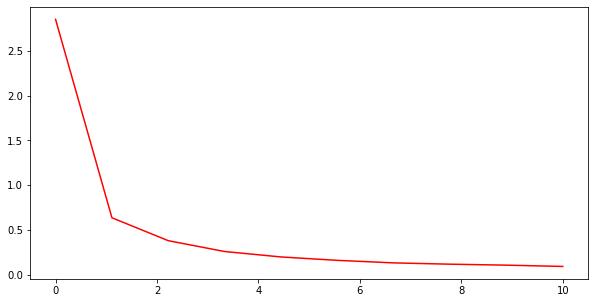

In [78]:
history = model_FFNN.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=10,
    verbose=1)

score = model_FFNN.evaluate(x_test, y_test)
print('Test loss:', score)
loss_history = history.history['loss']
plot.figure(figsize=[10, 5])
iterations, = plot.plot(np.linspace(
    0, len(loss_history), len(loss_history)), loss_history, color='red')
plot.show()


### Validating FFNN On **Train** Data


In [7]:
def print_train_prediction_ffnn(index):
    print(f"Prediction for index: {index}")

    print(f"input ---> {x_train[index]}")
    print(f"actual output ---> {y_train[index]}")
    print(f"predicted output ---> {model_FFNN.predict(x_test[index])}\n")


print_train_prediction_ffnn(0)
print_train_prediction_ffnn(1)
print_train_prediction_ffnn(2)
print_train_prediction_ffnn(3)
print_train_prediction_ffnn(4)


Prediction for index: 0
input ---> Horror DakotaFanning JosePabloCantillo
actual output ---> 7.2
predicted output ---> [[6.6577487]]

Prediction for index: 1
input ---> Action AdamRayner ElizaDushku IanOgilvy JamesRemar RogerMoore
actual output ---> 5.8
predicted output ---> [[6.0406365]]

Prediction for index: 2
input ---> Action SteveBoyle NicRhind RobertHobbs ChrisWilliamMartin TylerJohnston
actual output ---> 7.3
predicted output ---> [[6.62817]]

Prediction for index: 3
input ---> Action SigourneyWeaver EugeneKhumbanyiwa RobertHobbs CarlyPope BrandonAuret
actual output ---> 7.4
predicted output ---> [[6.815698]]

Prediction for index: 4
input ---> Action AdriannePalicki MichaelJaiWhite TyOlsson PascaleHutton SamJaeger
actual output ---> 5.2
predicted output ---> [[5.9267154]]



2021-11-24 14:26:39.105648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


### Validating FFNN On **Test** Data


In [8]:
def print_test_prediction_ffnn(index):
    print(f"Prediction for index: {index}")

    print(f"input ---> {x_test[index]}")
    print(f"actual output ---> {y_test[index]}")
    print(f"predicted output ---> {model_FFNN.predict(x_test[index])}\n")


print_test_prediction_ffnn(0)
print_test_prediction_ffnn(1)
print_test_prediction_ffnn(2)
print_test_prediction_ffnn(3)
print_test_prediction_ffnn(4)


Prediction for index: 0
input ---> ['Drama DannyGlover RonPerlman LindaHamilton ZoeWeizenbaum DavidStrathairn']
actual output ---> 6.1
predicted output ---> [[6.6577487]]

Prediction for index: 1
input ---> ['Action Ky-ManiMarley SpraggaBenz PaulCampbell LouieRankin WyclefJean']
actual output ---> 7.4
predicted output ---> [[6.0406365]]

Prediction for index: 2
input ---> ['Comedy MatthewMcConaughey JeffreyNordling WillieNelson WoodyHarrelson ZacharyKnighton']
actual output ---> 4.7
predicted output ---> [[6.62817]]

Prediction for index: 3
input ---> ['Drama PaulWalker PiperPerabo LambertWilson LindaCardellini ShawnHatosy']
actual output ---> 6.0
predicted output ---> [[6.815698]]

Prediction for index: 4
input ---> ['Comedy MollyShannon WillFerrell ElaineHendrix HarlandWilliams TomGreen']
actual output ---> 5.0
predicted output ---> [[5.9267154]]



<br><br><br><br><br><br><br><br><br><br>


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Recurrent Neural Network


### Building The RNN


In [79]:
model_RNN = tf.keras.Sequential([
    encoder,
    Layer.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=450),
    Layer.SimpleRNN(200, activation='relu'),
    Layer.Dense(60, activation='relu'),
    Layer.Dense(20, activation='relu'),
    # Layer.Dense(60, activation='relu'),
    # Layer.Dense(80, activation='relu'),
    Layer.Dense(1)
])

# model_RNN.summary()

model_RNN.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.RMSprop(.002))


### Training The RNN


Epoch 1/5
34/34 [==============================] - 3s 72ms/step - loss: 1.2992
Epoch 2/5
34/34 [==============================] - 2s 72ms/step - loss: 0.8730
Epoch 3/5
34/34 [==============================] - 2s 71ms/step - loss: 0.8009
Epoch 4/5
34/34 [==============================] - 2s 70ms/step - loss: 0.7217
Epoch 5/5
177/177 [==============================] - 2s 12ms/step - loss: 2.2070
Test loss: 2.2069849967956543


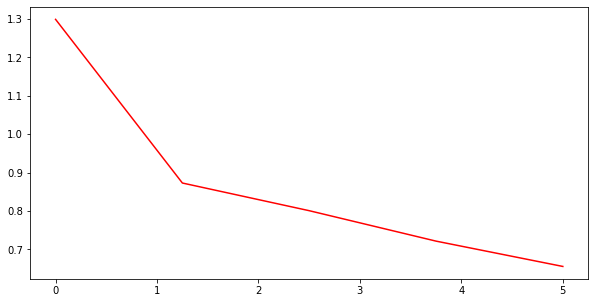

In [86]:
history = model_RNN.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=,
    verbose=1)

score = model_RNN.evaluate(x_test, y_test)
print('Test loss:', score)

loss_history = history.history['loss']
plot.figure(figsize=[10, 5])
iterations, = plot.plot(np.linspace(
    0, len(loss_history), len(loss_history)), loss_history, color='red')
plot.show()


### Validating RNN On **Train** Data


In [11]:
def print_train_prediction_rnn(index):
    print(f"Prediction for index: {index}")

    print(f"input ---> {x_train[index]}")
    print(f"actual output ---> {y_train[index]}")
    print(f"predicted output ---> {model_RNN.predict(x_test[index])}\n")


print_train_prediction_rnn(0)
print_train_prediction_rnn(1)
print_train_prediction_rnn(2)
print_train_prediction_rnn(3)
print_train_prediction_rnn(4)


Prediction for index: 0
input ---> Horror DakotaFanning JosePabloCantillo
actual output ---> 7.2
predicted output ---> [[6.1839967]]

Prediction for index: 1
input ---> Action AdamRayner ElizaDushku IanOgilvy JamesRemar RogerMoore
actual output ---> 5.8
predicted output ---> [[5.2453427]]

Prediction for index: 2
input ---> Action SteveBoyle NicRhind RobertHobbs ChrisWilliamMartin TylerJohnston
actual output ---> 7.3
predicted output ---> [[6.1285696]]

Prediction for index: 3
input ---> Action SigourneyWeaver EugeneKhumbanyiwa RobertHobbs CarlyPope BrandonAuret
actual output ---> 7.4
predicted output ---> [[5.937744]]

Prediction for index: 4
input ---> Action AdriannePalicki MichaelJaiWhite TyOlsson PascaleHutton SamJaeger
actual output ---> 5.2
predicted output ---> [[5.179338]]



2021-11-24 14:27:00.565410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


### Validating RNN On **Test** Data


In [12]:
def print_test_prediction_rnn(index):
    print(f"Prediction for index: {index}")

    print(f"input ---> {x_test[index]}")
    print(f"actual output ---> {y_test[index]}")
    print(f"predicted output ---> {model_RNN.predict(x_test[index])}\n")


print_test_prediction_rnn(0)
print_test_prediction_rnn(1)
print_test_prediction_rnn(2)
print_test_prediction_rnn(3)
print_test_prediction_rnn(4)


Prediction for index: 0
input ---> ['Drama DannyGlover RonPerlman LindaHamilton ZoeWeizenbaum DavidStrathairn']
actual output ---> 6.1
predicted output ---> [[6.1839967]]

Prediction for index: 1
input ---> ['Action Ky-ManiMarley SpraggaBenz PaulCampbell LouieRankin WyclefJean']
actual output ---> 7.4
predicted output ---> [[5.2453427]]

Prediction for index: 2
input ---> ['Comedy MatthewMcConaughey JeffreyNordling WillieNelson WoodyHarrelson ZacharyKnighton']
actual output ---> 4.7
predicted output ---> [[6.1285696]]

Prediction for index: 3
input ---> ['Drama PaulWalker PiperPerabo LambertWilson LindaCardellini ShawnHatosy']
actual output ---> 6.0
predicted output ---> [[5.937744]]

Prediction for index: 4
input ---> ['Comedy MollyShannon WillFerrell ElaineHendrix HarlandWilliams TomGreen']
actual output ---> 5.0
predicted output ---> [[5.179338]]



<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Niave Bayes Model


Total Correct Ratio: 14759/16989
0.8687385955618341


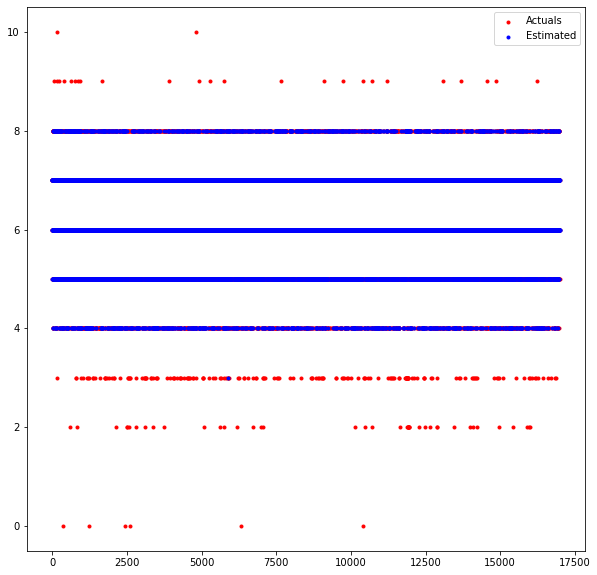

In [15]:
def naiveBayes(X, y):
    NBmodel = NB.CategoricalNB()
    NBmodel = NBmodel.fit(X, y)
    return NBmodel


def prepareForNB(data):
    all_actors = data['cast'].to_list()
    genres = data['genres'].to_list()

    X = []
    unique_keys = {'': 0}
    unique_key = 1

    for i in range(0, len(all_actors)):
        row = []

        raw_row = all_actors[i].split()
        raw_row.insert(0, genres[i])
        if len(raw_row) < 6:
            for i in range(0, 6 - len(raw_row)):
                raw_row.append('')

        for item in raw_row:
            if item not in unique_keys:
                unique_keys[item] = unique_key
                unique_key += 1
            row.append(unique_keys[item])

        X.append(row)

    genres = data['genres'].to_list()

    ratings = data['vote_average'].to_list()
    for i in range(0, len(ratings)):
        ratings[i] = round(ratings[i])

    return X, ratings


X, ratings = prepareForNB(movie_df)

data_count = movie_df.shape[0]
training_data_count = int(data_count * 0.75) + 1
test_data_count = data_count - training_data_count

nb_y_train = np.array(ratings[0:training_data_count])
nb_x_train = np.array(X[0:training_data_count])

nb_y_test = np.array(ratings[:-1 * test_data_count])
nb_x_test = np.array(X[:-1 * test_data_count])

NBmodel = naiveBayes(nb_x_train, nb_y_train)

y_pred = NBmodel.predict(nb_x_test)

total_correct = 0
for i in range(0, nb_y_test.shape[0]):
    if int(y_pred[i]) == nb_y_test[i]:
        total_correct += 1

test_size = nb_y_test.shape[0]
accuracy = total_correct/test_size
print(f"Total Correct Ratio: {total_correct}/{nb_y_test.shape[0]}")
print(accuracy)

plot.figure(figsize=[10, 10])
actuals = plot.scatter(np.linspace(0, test_size, test_size),
                       nb_y_test, color='red', marker='.')
estimates = plot.scatter(np.linspace(
    0, test_size, test_size), y_pred, color='blue', marker='.')
plot.legend([actuals, estimates], ["Actuals", "Estimated"])
plot.show()
